In [2]:
# Install dependencies
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install pandas
!pip install tqdm

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce 940MX


In [4]:
# Imports
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

Running on device: cuda


In [5]:
# Path to the dataset file (change if required)
DATASET_PATH = r"G:\VLSI\IC_technology\Project\project-root\data\WM811K.pkl"

# Load the dataset
with open(DATASET_PATH, 'rb') as f:
    data = pickle.load(f)

# Check keys in the loaded data
print(data.keys())

C:\Users\lenovo\AppData\Local\Temp\ipykernel_16976\3236857814.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


Index(['dieSize', 'failureType', 'lotName', 'trainTestLabel', 'waferIndex',
       'waferMap'],
      dtype='object')


In [6]:
import pandas as pd

# Load the dataset (it's a DataFrame)
with open(DATASET_PATH, 'rb') as f:
    data = pickle.load(f)

# Check the shape and column names
print(data.shape)
print(data.columns)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_16976\3421921335.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


(811457, 6)
Index(['dieSize', 'failureType', 'lotName', 'trainTestLabel', 'waferIndex',
       'waferMap'],
      dtype='object')


In [7]:
# Display first few rows
data.head()

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


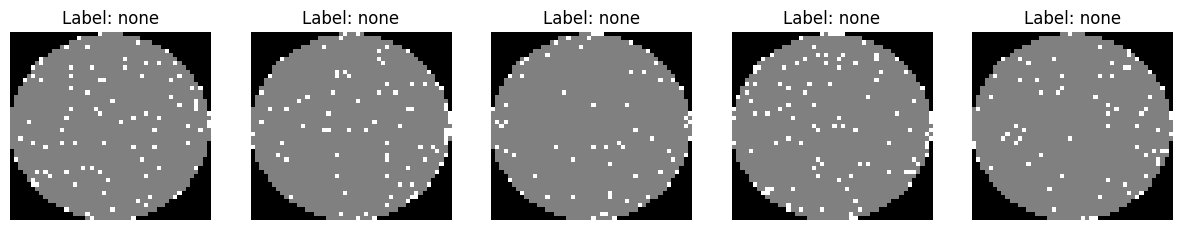

In [8]:
# Plot 5 wafer maps from your data
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    wafer_map = data.iloc[i]['waferMap']
    label = data.iloc[i]['failureType']
    plt.imshow(wafer_map, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.show()

In [9]:
from PIL import Image
from torchvision import transforms

class WaferDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.labels = dataframe['failureType'].values
        self.wafer_maps = dataframe['waferMap'].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        wafer_map = self.wafer_maps[idx]
        label = self.labels[idx]

        # Convert numpy array to PIL Image for torchvision transforms
        wafer_img = Image.fromarray(np.uint8(wafer_map * 255))  # Scale to 0-255 if not already

        if self.transform:
            wafer_img = self.transform(wafer_img)

        return wafer_img, label

In [10]:
# Define transforms (no median filter yet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts to [0,1] tensor automatically
])

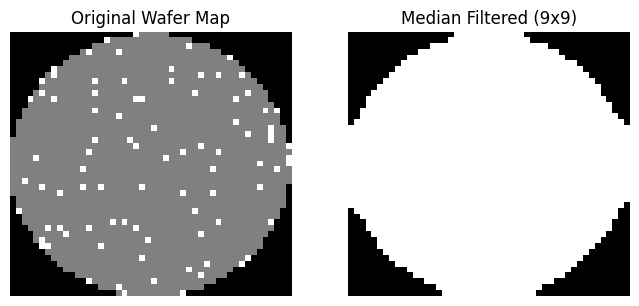

In [11]:
from PIL import Image, ImageFilter

# Pick a sample wafer image from your dataframe
sample_wafer = data.iloc[0]['waferMap']

# Convert numpy array to PIL image
wafer_img = Image.fromarray(sample_wafer.astype(np.uint8))

# Apply Median filter with size 9
wafer_filtered = wafer_img.filter(ImageFilter.MedianFilter(size=9))

# Plot original and filtered image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(wafer_img, cmap='gray')
plt.title('Original Wafer Map')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wafer_filtered, cmap='gray')
plt.title('Median Filtered (9x9)')
plt.axis('off')

plt.show()


In [12]:
# Flatten the failureType column: if it's a numpy array, extract its first element
def extract_label(x):
    if isinstance(x, (np.ndarray, list)):
        return x[0]
    else:
        return x

# Apply to the whole column
data['failureType'] = data['failureType'].apply(extract_label)

# Now check the types
print(data['failureType'].apply(type).value_counts())  # Should show only <class 'str'>

failureType
<class 'numpy.uint64'>    638507
<class 'str'>             172950
Name: count, dtype: int64


In [13]:
# Keep only rows where failureType is a string (the labeled wafer maps)
data = data[data['failureType'].apply(lambda x: isinstance(x, str))].reset_index(drop=True)

# Confirm the fix
print(data['failureType'].apply(type).value_counts())

failureType
<class 'str'>    172950
Name: count, dtype: int64


In [14]:
# Now the unique class names should work correctly
class_names = sorted(data['failureType'].unique())
print("Class names:", class_names)

class_to_idx = {label: idx for idx, label in enumerate(class_names)}
print("Class to index mapping:", class_to_idx)

Class names: ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none']
Class to index mapping: {'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3, 'Loc': 4, 'Near-full': 5, 'Random': 6, 'Scratch': 7, 'none': 8}


In [15]:
class WaferDataset(Dataset):
    def __init__(self, dataframe, transform=None, apply_filter=True):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.apply_filter = apply_filter
        self.wafer_maps = dataframe['waferMap'].values
        self.labels = dataframe['failureType'].map(class_to_idx).values  # Convert to numeric labels

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        wafer_map = self.wafer_maps[idx]

        # Convert numpy to PIL image
        wafer_img = Image.fromarray(np.uint8(wafer_map * 255))  # scale to 0-255

        # Apply median filtering
        if self.apply_filter:
            wafer_img = wafer_img.filter(ImageFilter.MedianFilter(size=9))

        # Apply additional transforms like resizing, normalization
        if self.transform:
            wafer_img = self.transform(wafer_img)

        # Get numeric label
        label = self.labels[idx]

        return wafer_img, label

In [16]:
# Split the labeled data into train/test
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['failureType'], random_state=42)

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create dataset objects
train_dataset = WaferDataset(train_df, transform=transform, apply_filter=True)
test_dataset = WaferDataset(test_df, transform=transform, apply_filter=True)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Test dataloader output
for images, labels in train_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch: {labels}")
    break

Image batch shape: torch.Size([32, 1, 224, 224])
Label batch: tensor([8, 4, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8,
        8, 8, 8, 3, 3, 8, 8, 8])


In [17]:
# Function to convert multi-class label to binary (defect: 1, none: 0)
def label_to_binary(label):
    return 0 if label == class_to_idx['none'] else 1

# Create new Datasets with binary labels
class BinaryWaferDataset(WaferDataset):
    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)
        binary_label = label_to_binary(label)
        return image, binary_label

# Create train/test binary datasets
train_dataset_binary = BinaryWaferDataset(train_df, transform=transform, apply_filter=True)
test_dataset_binary = BinaryWaferDataset(test_df, transform=transform, apply_filter=True)

# Create DataLoaders
train_loader_binary = DataLoader(train_dataset_binary, batch_size=batch_size, shuffle=True)
test_loader_binary = DataLoader(test_dataset_binary, batch_size=batch_size, shuffle=False)

# Test batch
for images, labels in train_loader_binary:
    print(f"Binary labels batch: {labels}")
    break

Binary labels batch: tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0])


In [18]:
# Load pre-trained ResNet18
resnet18 = models.resnet18(pretrained=True)

# Modify first conv layer to accept 1-channel images
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify final fully connected layer for binary classification (2 output classes)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)

# Move to GPU if available
resnet18 = resnet18.to(device)

# Print the model summary
print(resnet18)

g:\VLSI\IC_technology\Project\project-root\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
g:\VLSI\IC_technology\Project\project-root\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Because we have two classes (0 or 1)
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

# Accuracy function
def calculate_accuracy(y_pred, y_true):
    predicted = torch.argmax(y_pred, dim=1)
    correct = (predicted == y_true).sum().item()
    accuracy = correct / y_true.size(0)
    return accuracy

In [20]:
num_epochs = 5

for epoch in range(num_epochs):
    resnet18.train()  # Set model to training mode
    running_loss = 0.0
    running_acc = 0.0

    for images, labels in tqdm(train_loader_binary, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        acc = calculate_accuracy(outputs, labels)

        running_loss += loss.item()
        running_acc += acc

    epoch_loss = running_loss / len(train_loader_binary)
    epoch_acc = running_acc / len(train_loader_binary)

    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/5: 100%|██████████| 4324/4324 [1:02:33<00:00,  1.15it/s]


[Epoch 1] Loss: 0.1856, Accuracy: 0.9429


Epoch 2/5: 100%|██████████| 4324/4324 [1:03:31<00:00,  1.13it/s]


[Epoch 2] Loss: 0.1508, Accuracy: 0.9565


Epoch 3/5: 100%|██████████| 4324/4324 [1:03:24<00:00,  1.14it/s]


[Epoch 3] Loss: 0.1314, Accuracy: 0.9621


Epoch 4/5: 100%|██████████| 4324/4324 [1:02:45<00:00,  1.15it/s]


[Epoch 4] Loss: 0.1254, Accuracy: 0.9640


Epoch 5/5: 100%|██████████| 4324/4324 [1:02:44<00:00,  1.15it/s]

[Epoch 5] Loss: 0.1226, Accuracy: 0.9646


In [21]:
# Evaluation
resnet18.eval()  # Set model to eval mode
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for images, labels in test_loader_binary:
        images, labels = images.to(device), labels.to(device)

        outputs = resnet18(images)
        loss = criterion(outputs, labels)

        acc = calculate_accuracy(outputs, labels)

        test_loss += loss.item()
        test_acc += acc

test_loss /= len(test_loader_binary)
test_acc /= len(test_loader_binary)

print(f"[Test] Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

[Test] Loss: 10.9092, Accuracy: 0.1478


In [22]:
# Multi-class train/test datasets (already done earlier)
train_dataset_multi = WaferDataset(train_df, transform=transform, apply_filter=True)
test_dataset_multi = WaferDataset(test_df, transform=transform, apply_filter=True)

# Multi-class DataLoaders
train_loader_multi = DataLoader(train_dataset_multi, batch_size=batch_size, shuffle=True)
test_loader_multi = DataLoader(test_dataset_multi, batch_size=batch_size, shuffle=False)

# Test one batch
for images, labels in train_loader_multi:
    print(f"Multi-class labels batch: {labels}")
    break

Multi-class labels batch: tensor([2, 8, 3, 8, 2, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 3, 8, 8, 8, 8, 8])


In [23]:
# Reload pre-trained ResNet18
resnet18_multi = models.resnet18(pretrained=True)

# Change input conv1 to 1-channel
resnet18_multi.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify final fully connected layer to 9 output classes
resnet18_multi.fc = nn.Linear(resnet18_multi.fc.in_features, 9)

# Move to device
resnet18_multi = resnet18_multi.to(device)

# Print summary
print(resnet18_multi)

g:\VLSI\IC_technology\Project\project-root\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
g:\VLSI\IC_technology\Project\project-root\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# Loss function for multi-class
criterion_multi = nn.CrossEntropyLoss()

# Optimizer
optimizer_multi = optim.Adam(resnet18_multi.parameters(), lr=0.001)

# Accuracy function (same as before)
def calculate_accuracy_multi(y_pred, y_true):
    predicted = torch.argmax(y_pred, dim=1)
    correct = (predicted == y_true).sum().item()
    accuracy = correct / y_true.size(0)
    return accuracy

In [25]:
num_epochs = 5

for epoch in range(num_epochs):
    resnet18_multi.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, labels in tqdm(train_loader_multi, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer_multi.zero_grad()

        outputs = resnet18_multi(images)
        loss = criterion_multi(outputs, labels)
        loss.backward()
        optimizer_multi.step()

        acc = calculate_accuracy_multi(outputs, labels)

        running_loss += loss.item()
        running_acc += acc

    epoch_loss = running_loss / len(train_loader_multi)
    epoch_acc = running_acc / len(train_loader_multi)

    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/5: 100%|██████████| 4324/4324 [1:04:37<00:00,  1.12it/s]


[Epoch 1] Loss: 0.2987, Accuracy: 0.9256


Epoch 2/5: 100%|██████████| 4324/4324 [1:02:48<00:00,  1.15it/s]


[Epoch 2] Loss: 0.2363, Accuracy: 0.9400


Epoch 3/5: 100%|██████████| 4324/4324 [1:03:13<00:00,  1.14it/s]


[Epoch 3] Loss: 0.2134, Accuracy: 0.9452


Epoch 4/5: 100%|██████████| 4324/4324 [1:01:52<00:00,  1.16it/s]


[Epoch 4] Loss: 0.2004, Accuracy: 0.9482


Epoch 5/5: 100%|██████████| 4324/4324 [1:01:36<00:00,  1.17it/s]

[Epoch 5] Loss: 0.1915, Accuracy: 0.9507


In [26]:
# Evaluation
resnet18_multi.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for images, labels in test_loader_multi:
        images, labels = images.to(device), labels.to(device)

        outputs = resnet18_multi(images)
        loss = criterion_multi(outputs, labels)

        acc = calculate_accuracy_multi(outputs, labels)

        test_loss += loss.item()
        test_acc += acc

test_loss /= len(test_loader_multi)
test_acc /= len(test_loader_multi)

print(f"[Test] Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

[Test] Loss: 0.5203, Accuracy: 0.8960


In [ ]:
# Create a feature extractor from trained resnet18_multi
from torch import nn

class ResNetFeatureExtractor(nn.Module):
    def __init__(self, model):
        super(ResNetFeatureExtractor, self).__init__()
        # Everything except the final fc layer
        self.features = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4,
            model.avgpool,  # outputs 512-dim (1, 512, 1, 1)
        )

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)  # flatten (B, 512)

# Instantiate and freeze
feature_extractor = ResNetFeatureExtractor(resnet18_multi).to(device)
feature_extractor.eval()

ResNetFeatureExtractor(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

: 

In [ ]:
# ✅ Safer version (writes to disk, no RAM crash)
import os

features_list = []
labels_list = []
image_paths = []
save_every = 1000
counter = 0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader_multi, desc="Extracting & Saving Features")):
        images = images.to(device)
        features = feature_extractor(images).cpu().numpy()

        features_list.append(features)
        labels_list.append(labels.numpy())
        image_paths.append(images.cpu().numpy())

        counter += len(images)

        if counter >= save_every:
            np.savez_compressed(f"features_chunk_{batch_idx}.npz",
                                features=np.concatenate(features_list, axis=0),
                                labels=np.concatenate(labels_list, axis=0),
                                images=np.concatenate(image_paths, axis=0))
            features_list, labels_list, image_paths = [], [], []
            counter = 0

# Final chunk save
if features_list:
    np.savez_compressed(f"features_chunk_final.npz",
                        features=np.concatenate(features_list, axis=0),
                        labels=np.concatenate(labels_list, axis=0),
                        images=np.concatenate(image_paths, axis=0))

Extracting Features:  40%|███▉      | 1716/4324 [09:07<12:13,  3.55it/s] 

In [ ]:
import glob

X_features, Y_labels, X_images = [], [], []

for file in sorted(glob.glob("features_chunk_*.npz")):
    data = np.load(file)
    X_features.append(data["features"])
    Y_labels.append(data["labels"])
    X_images.append(data["images"])

# Final combined arrays
X_features = np.concatenate(X_features, axis=0)
Y_labels = np.concatenate(Y_labels, axis=0)
X_images = np.concatenate(X_images, axis=0)

print("Loaded features shape:", X_features.shape)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Step 1: PCA to reduce to 256 dims
pca = PCA(n_components=256)
X_pca = pca.fit_transform(X_features)

# Step 2: Normalize features to [0, 1] for similarity search
scaler = MinMaxScaler()
X_pca_norm = scaler.fit_transform(X_pca)

print("Reduced feature shape:", X_pca_norm.shape)  # Should be (N, 256)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_similar_wafer(query_img_tensor, top_k=5):
    # Preprocess & extract embedding
    feature_extractor.eval()
    with torch.no_grad():
        query_img_tensor = query_img_tensor.unsqueeze(0).to(device)  # Add batch dim
        embedding = feature_extractor(query_img_tensor).cpu().numpy()  # (1, 512)

    # Apply PCA + normalization
    query_pca = pca.transform(embedding)
    query_norm = scaler.transform(query_pca)

    # Compute cosine similarity
    similarities = cosine_similarity(query_norm, X_pca_norm)[0]  # shape: (N,)

    # Get top K indices
    top_k_indices = np.argsort(similarities)[::-1][:top_k]

    return top_k_indices, similarities[top_k_indices]

In [ ]:
def show_similar_wafers(query_img, top_indices, scores):
    plt.figure(figsize=(15, 3))

    # Plot query
    plt.subplot(1, len(top_indices)+1, 1)
    plt.imshow(query_img.squeeze(), cmap='gray')
    plt.title("Query Image")
    plt.axis('off')

    # Plot top-k retrieved
    for i, idx in enumerate(top_indices):
        plt.subplot(1, len(top_indices)+1, i+2)
        plt.imshow(X_images[idx].squeeze(), cmap='gray')
        plt.title(f"Sim #{i+1} (Score: {scores[i]:.2f})\nClass: {class_names[Y_labels[idx]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Pick a random test wafer image
query_img_tensor, true_label = test_dataset_multi[5]  # Change index if needed

# Retrieve similar wafers
top_k_idx, top_k_scores = retrieve_similar_wafer(query_img_tensor)

# Show results
show_similar_wafers(query_img_tensor, top_k_idx, top_k_scores)